# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from feature_engine.outliers import Winsorizer

import gower
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

#  Data Loading

In [ ]:
# Load Dataset
data = pd.read_csv('data_for_modelling.csv')

# Display 5 rows
data.head()

,date,status,fulfilment,sales_channel,ship_service_level,category,size,amazon_standard_id,qty,currency,sales,clean_ship_state,promotion_used
0,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XL,B07WV4JV4D,1,INR,329.0,Maharashtra,True
1,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Top,3XL,B098714BZP,1,INR,574.0,Tamil Nadu,False
2,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,XL,B08YN7XDSG,1,INR,824.0,Uttar Pradesh,True
3,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,L,B08CMHNWBN,1,INR,653.0,Chandigarh,True
4,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XXL,B08B3XF5MH,1,INR,363.0,Tamil Nadu,False


In [7]:
df = data.copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77692 entries, 0 to 77691
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                77692 non-null  object 
 1   status              77692 non-null  object 
 2   fulfilment          77692 non-null  object 
 3   sales_channel       77692 non-null  object 
 4   ship_service_level  77692 non-null  object 
 5   category            77692 non-null  object 
 6   size                77692 non-null  object 
 7   amazon_standard_id  77692 non-null  object 
 8   qty                 77692 non-null  int64  
 9   currency            77692 non-null  object 
 10  sales               77692 non-null  float64
 11  clean_ship_state    77692 non-null  object 
 12  promotion_used      77692 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 7.2+ MB


# Feature Engineering

In [9]:
# Change data type
df['date']= pd.to_datetime(df['date'])
df['promo_used'] = df['promotion_used'].astype(int)

In [10]:
# groupby table by amazon_standard_id
agg_df = df.groupby('amazon_standard_id').agg({
    'qty': ['sum', 'mean'],
    'sales': ['sum', 'mean'],
    'promotion_used': 'mean',
    'category': lambda x: x.mode()[0],
    'size': lambda x: x.mode()[0],
    'clean_ship_state': lambda x: x.mode()[0],
    'date' : ['min', 'max', 'count']
})

agg_df.columns = [
    'total_qty', 'avg_qty_per_order',
    'total_sales', 'avg_sales_per_order',
    'promo_used_ratio',
    'freq_category',
    'freq_size',
    'freq_ship_state',
    'last_order_date', 'first_order_date', 'total_transactions'
]

agg_df = agg_df.reset_index()

# Recency Feature
agg_df['last_order_date'] = pd.to_datetime(agg_df['last_order_date'])
agg_df['recency_days'] = (df['date'].max() - agg_df['last_order_date']).dt.days

In [11]:
agg_df

,amazon_standard_id,total_qty,avg_qty_per_order,total_sales,avg_sales_per_order,promo_used_ratio,freq_category,freq_size,freq_ship_state,last_order_date,first_order_date,total_transactions,recency_days
0,B01LYC0N7Q,3,1.0,1230.0,410.000000,0.333333,kurta,XL,Delhi,2022-04-02,2022-06-25,3,88
1,B01LYC0NV1,10,1.0,2986.0,298.600000,0.700000,kurta,XL,Tamil Nadu,2022-04-06,2022-06-15,10,84
2,B01LZMXYSV,5,1.0,1499.0,299.800000,0.800000,kurta,S,Karnataka,2022-04-08,2022-06-24,5,82
3,B01LZYQ93J,4,1.0,1204.0,301.000000,0.750000,kurta,M,Tamil Nadu,2022-06-04,2022-06-23,4,25
4,B01M0LXTZE,7,1.0,2644.0,377.714286,0.857143,kurta,M,Karnataka,2022-04-14,2022-05-09,7,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6542,B0B3X1PX3P,2,1.0,2476.0,1238.000000,1.000000,Set,M,Bihar,2022-06-24,2022-06-27,2,5
6543,B0B3X1ZSZP,3,1.5,2313.0,1156.500000,1.000000,Set,3XL,Andhra Pradesh,2022-06-24,2022-06-26,2,5
6544,B0B3X2392D,1,1.0,1238.0,1238.000000,1.000000,Set,XXL,Assam,2022-06-24,2022-06-24,1,5
6545,B0B3X2WPTW,2,1.0,2485.0,1242.500000,1.000000,Set,XXL,Jharkhand,2022-06-23,2022-06-25,2,6


In [12]:
cluster_df = agg_df.drop(columns=['amazon_standard_id','last_order_date','first_order_date'])

In [13]:
num_cols = cluster_df[['total_qty',	'avg_qty_per_order', 'total_sales',	'avg_sales_per_order', 'promo_used_ratio', 'total_transactions', 'recency_days']]

In [14]:
def check_skewness(df):
    list_corr = []

    for col in df.columns:
        skew_val = round(df[col].skew(), 1)

        if -0.5 <= skew_val <= 0.5:
            distribusi = 'normal'
        elif -1 <= skew_val <= 1:
            distribusi = 'moderate skewed'
        else:
            distribusi = 'highly skewed'

        list_corr.append({
            'fitur': col,
            'skewness': skew_val,
            'distribusi': distribusi
        })

    return pd.DataFrame(list_corr)

In [15]:
skewness = check_skewness(num_cols)
skewness

,fitur,skewness,distribusi
0,total_qty,6.5,highly skewed
1,avg_qty_per_order,46.4,highly skewed
2,total_sales,8.7,highly skewed
3,avg_sales_per_order,1.1,highly skewed
4,promo_used_ratio,-0.5,normal
5,total_transactions,6.5,highly skewed
6,recency_days,-1.4,highly skewed


In [ ]:
# Calculate upper boundary, lower boundary, and percentage of outliers

# Initialize empty lists to store results
column = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range (0, len(skewness)):
  col = skewness['fitur'][row]

  # Calculate upper and lower boundaries based on distribution type
  if skewness['distribusi'][row] == 'highly skewed':
    IQR = cluster_df[col].quantile(0.75) - cluster_df[col].quantile(0.25)
    lower_boundary = cluster_df[col].quantile(0.25) - (IQR * 3)
    upper_boundary = cluster_df[col].quantile(0.75) + (IQR * 3)
  elif skewness['distribusi'][row] == 'moderate skewed':
    IQR = cluster_df[col].quantile(0.75) - cluster_df[col].quantile(0.25)
    lower_boundary = cluster_df[col].quantile(0.25) - (IQR * 1.5)
    upper_boundary = cluster_df[col].quantile(0.75) + (IQR * 1.5)
  else:
    lower_boundary = cluster_df[col].mean() - 3* cluster_df[col].std()
    upper_boundary = cluster_df[col].mean() + 3* cluster_df[col].std()

  # Append results to lists
  column.append(col)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(cluster_df[cluster_df[col] > upper_boundary]) / len(cluster_df) * 100) + (len(cluster_df[cluster_df[col] < lower_boundary]) / len(cluster_df) * 100))
  percent_total_outlier.append(totout)

# Create dataframe
outliers = pd.DataFrame({
    'column': column,

    'upper_boundary': [round(upper_bound,2) for upper_bound in upper_bound],
    'lower_boundary': [round(lower_bound,2) for lower_bound in lower_bound],
    'percentage_total_outlier': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})
outliers

,column,upper_boundary,lower_boundary,percentage_total_outlier
0,total_qty,42.00,-28.00,5.38
1,avg_qty_per_order,1.00,1.00,3.18
2,total_sales,26148.00,-17626.50,6.37
3,avg_sales_per_order,1774.74,-577.29,0.03
4,promo_used_ratio,1.54,-0.26,0.00
5,total_transactions,40.00,-26.50,5.68
6,recency_days,161.00,-14.00,0.00


In [17]:
selected_cols=['total_qty', 'avg_qty_per_order', 'total_sales', 'total_transactions']

In [18]:
# capping
winsoriser = Winsorizer(capping_method='quantiles',
                            tail='both',
                            fold=0.01,
                            variables= selected_cols,
                            missing_values='ignore')

cluster_df = winsoriser.fit_transform(cluster_df)

In [19]:
cluster_df.head()

,total_qty,avg_qty_per_order,total_sales,avg_sales_per_order,promo_used_ratio,freq_category,freq_size,freq_ship_state,total_transactions,recency_days
0,3,1.0,1230.0,410.000000,0.333333,kurta,XL,Delhi,3,88
1,10,1.0,2986.0,298.600000,0.700000,kurta,XL,Tamil Nadu,10,84
2,5,1.0,1499.0,299.800000,0.800000,kurta,S,Karnataka,5,82
3,4,1.0,1204.0,301.000000,0.750000,kurta,M,Tamil Nadu,4,25
4,7,1.0,2644.0,377.714286,0.857143,kurta,M,Karnataka,7,76


In [ ]:
# Compute Gower distance matrix for mixed-type data
gower_dist = gower.gower_matrix(cluster_df)

In [ ]:
# Perform hierarchical clustering using average linkage
linkage_matrix = linkage(gower_dist, method='average')

C:\Users\Acer\AppData\Local\Temp\ipykernel_3872\2796066900.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(gower_dist, method='average')


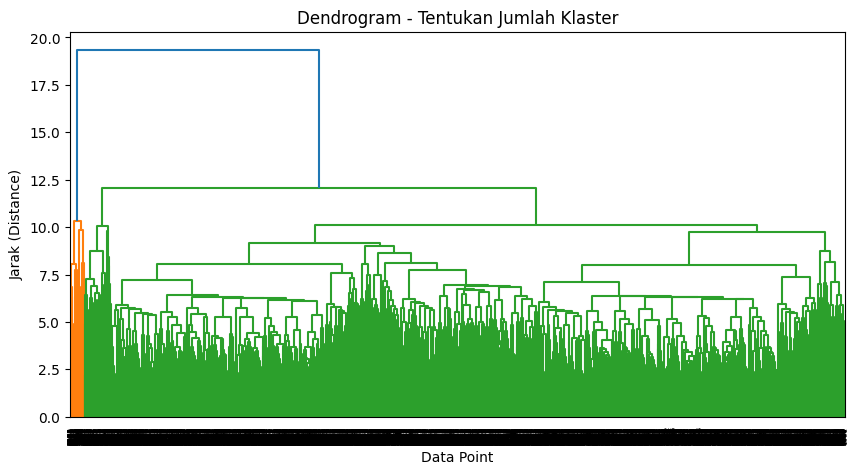

In [ ]:
# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Dendrogram - Tentukan Jumlah Klaster")
plt.xlabel("Data Point")
plt.ylabel("Jarak (Distance)")
plt.show()

In [23]:
scores = []
range_n_clusters = range(2, 7)

for n in range_n_clusters:
    model = AgglomerativeClustering(n_clusters=n, metric='precomputed', linkage='average')
    labels = model.fit_predict(gower_dist)
    
    score = silhouette_score(gower_dist, labels, metric='precomputed')
    print(f'Jumlah Klaster: {n} -> Silhouette Score: {score:.4f}')
    scores.append(score)

Jumlah Klaster: 2 -> Silhouette Score: 0.3072
Jumlah Klaster: 3 -> Silhouette Score: 0.1996
Jumlah Klaster: 4 -> Silhouette Score: 0.1420
Jumlah Klaster: 5 -> Silhouette Score: 0.1273
Jumlah Klaster: 6 -> Silhouette Score: 0.0776


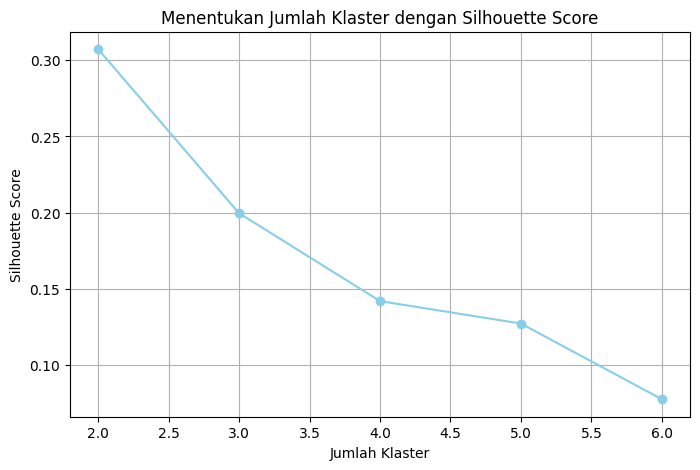

In [24]:
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, scores, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Silhouette Score')
plt.title('Menentukan Jumlah Klaster dengan Silhouette Score')
plt.grid(True)
plt.show()

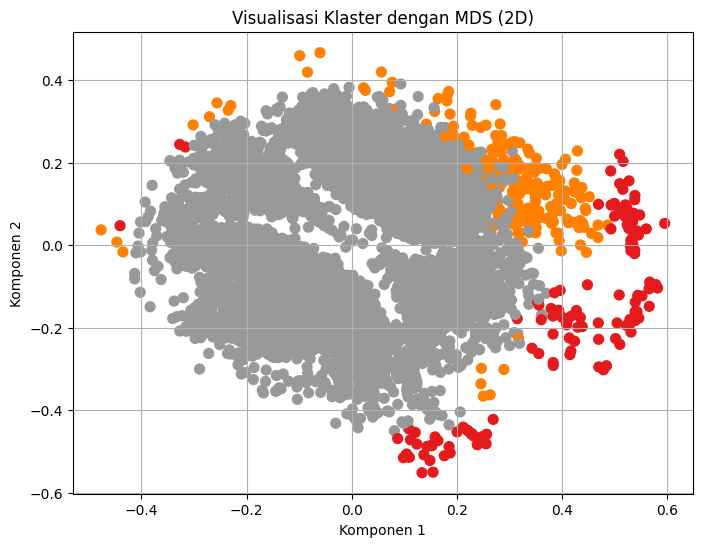

In [ ]:
# Cut dendrogram into 3 clusters
cluster_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
gower_2d = mds.fit_transform(gower_dist)

# Plot scatterplot clustering
plt.figure(figsize=(8, 6))
plt.scatter(gower_2d[:, 0], gower_2d[:, 1], c=cluster_labels, cmap='Set1', s=50)
plt.title('Visualisasi Klaster dengan MDS (2D)')
plt.xlabel('Komponen 1')
plt.ylabel('Komponen 2')
plt.grid(True)
plt.show()


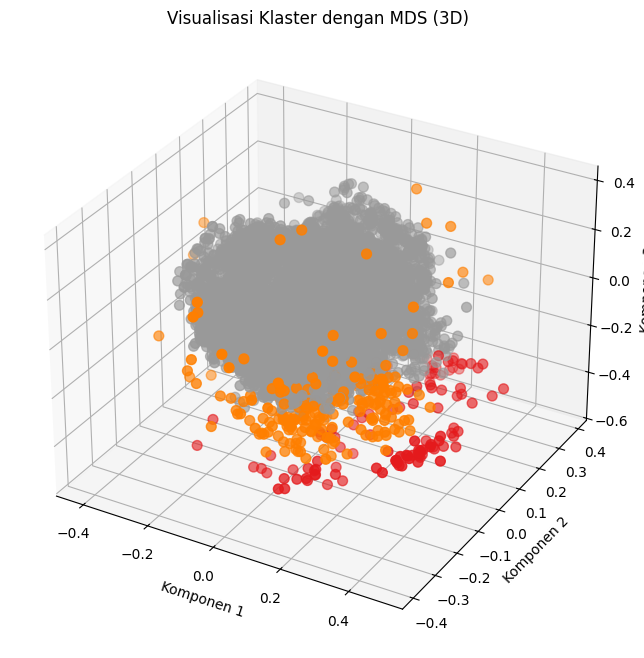

In [ ]:
# MDS for 3D
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
gower_3d = mds.fit_transform(gower_dist)

# 3D Visualization of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    gower_3d[:, 0], gower_3d[:, 1], gower_3d[:, 2],
    c=cluster_labels,
    cmap='Set1',
    s=50
)

ax.set_title('Visualisasi Klaster dengan MDS (3D)')
ax.set_xlabel('Komponen 1')
ax.set_ylabel('Komponen 2')
ax.set_zlabel('Komponen 3')

plt.show()


In [ ]:
# Create a DataFrame for 3D plotting
df_plot = pd.DataFrame(gower_3d, columns=['Komponen 1', 'Komponen 2', 'Komponen 3'])
df_plot['Klaster'] = cluster_labels.astype(str)  # supaya warnanya beda per klaster

# 3D Scatter Plot using Plotly
fig = px.scatter_3d(
    df_plot,
    x='Komponen 1',
    y='Komponen 2',
    z='Komponen 3',
    color='Klaster',
    title='Visualisasi Klaster dengan MDS (3D - Plotly)',
    opacity=0.8,
    width=800,
    height=600
)

fig.show()


In [ ]:
# Add the cluster labels as a new column to the agg_df DataFrame
agg_df['cluster'] = cluster_labels
agg_df

,amazon_standard_id,total_qty,avg_qty_per_order,total_sales,avg_sales_per_order,promo_used_ratio,freq_category,freq_size,freq_ship_state,last_order_date,first_order_date,total_transactions,recency_days,cluster
0,B01LYC0N7Q,3,1.0,1230.0,410.000000,0.333333,kurta,XL,Delhi,2022-04-02,2022-06-25,3,88,3
1,B01LYC0NV1,10,1.0,2986.0,298.600000,0.700000,kurta,XL,Tamil Nadu,2022-04-06,2022-06-15,10,84,3
2,B01LZMXYSV,5,1.0,1499.0,299.800000,0.800000,kurta,S,Karnataka,2022-04-08,2022-06-24,5,82,3
3,B01LZYQ93J,4,1.0,1204.0,301.000000,0.750000,kurta,M,Tamil Nadu,2022-06-04,2022-06-23,4,25,3
4,B01M0LXTZE,7,1.0,2644.0,377.714286,0.857143,kurta,M,Karnataka,2022-04-14,2022-05-09,7,76,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6542,B0B3X1PX3P,2,1.0,2476.0,1238.000000,1.000000,Set,M,Bihar,2022-06-24,2022-06-27,2,5,3
6543,B0B3X1ZSZP,3,1.5,2313.0,1156.500000,1.000000,Set,3XL,Andhra Pradesh,2022-06-24,2022-06-26,2,5,2
6544,B0B3X2392D,1,1.0,1238.0,1238.000000,1.000000,Set,XXL,Assam,2022-06-24,2022-06-24,1,5,3
6545,B0B3X2WPTW,2,1.0,2485.0,1242.500000,1.000000,Set,XXL,Jharkhand,2022-06-23,2022-06-25,2,6,3


In [30]:
cluster1 = agg_df[agg_df['cluster']==1].reset_index(drop=True)
cluster1

,amazon_standard_id,total_qty,avg_qty_per_order,total_sales,avg_sales_per_order,promo_used_ratio,freq_category,freq_size,freq_ship_state,last_order_date,first_order_date,total_transactions,recency_days,cluster
0,B07GRSF1FC,113,1.027273,41927.0,381.154545,0.490909,kurta,M,Maharashtra,2022-04-02,2022-06-28,110,88,1
1,B07H7DZXJ5,90,1.011236,46537.0,522.887640,0.831461,kurta,XXL,Tamil Nadu,2022-03-31,2022-06-23,89,90,1
2,B07R41RZV7,114,1.008850,52196.0,461.911504,0.336283,kurta,XXL,Tamil Nadu,2022-04-01,2022-06-26,113,89,1
3,B07R4XJNW3,188,1.016216,84816.0,458.464865,0.400000,kurta,XL,Tamil Nadu,2022-03-31,2022-06-24,185,90,1
4,B07R52578F,131,1.000000,60308.0,460.366412,0.358779,kurta,M,Tamil Nadu,2022-04-05,2022-06-28,131,85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,B09SDYQ3WG,179,1.000000,135755.0,758.407821,0.927374,Western Dress,S,Karnataka,2022-04-13,2022-06-29,179,77,1
124,B09SDZ4FH9,100,1.000000,74228.0,742.280000,0.730000,kurta,M,Telangana,2022-04-01,2022-06-24,100,89,1
125,B09SDZ64HF,54,1.018868,40334.0,761.018868,0.867925,Western Dress,3XL,Maharashtra,2022-04-01,2022-06-25,53,89,1
126,B09TH4H7T2,71,1.000000,52073.0,733.422535,0.929577,Western Dress,S,Karnataka,2022-05-21,2022-06-25,71,39,1


In [31]:
cluster1.describe().T

,count,mean,std,min,25%,50%,75%,max
total_qty,128.0,135.828125,66.743971,48.000000,96.750000,122.000000,156.250000,427.000000
avg_qty_per_order,128.0,1.004329,0.007960,1.000000,1.000000,1.000000,1.006879,1.053691
total_sales,128.0,91943.062500,60088.645275,26781.000000,55258.750000,78154.000000,103159.000000,430948.000000
avg_sales_per_order,128.0,685.838029,216.991865,376.980132,494.697654,660.735979,816.943534,1454.729730
promo_used_ratio,128.0,0.594324,0.170930,0.269841,0.474889,0.542262,0.717793,0.958763
total_transactions,128.0,135.250000,66.526888,48.000000,96.750000,121.000000,154.250000,427.000000
recency_days,128.0,86.343750,8.723610,26.000000,87.000000,89.000000,89.000000,90.000000
cluster,128.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
cluster2 = agg_df[agg_df['cluster']==2].reset_index(drop=True)
cluster2

,amazon_standard_id,total_qty,avg_qty_per_order,total_sales,avg_sales_per_order,promo_used_ratio,freq_category,freq_size,freq_ship_state,last_order_date,first_order_date,total_transactions,recency_days,cluster
0,B077Z2H3PS,2,2.000000,586.0,586.000000,0.000000,Blouse,Free,Gujarat,2022-04-28,2022-04-28,1,62,2
1,B077Z7WDXN,16,8.000000,975.0,487.500000,0.500000,Blouse,Free,Gujarat,2022-04-17,2022-04-30,2,73,2
2,B077Z7WHCR,18,1.125000,6751.0,421.937500,0.250000,Blouse,Free,Telangana,2022-04-01,2022-06-28,16,89,2
3,B07Q2M4W2P,25,1.086957,14851.0,645.695652,0.739130,Set,S,Karnataka,2022-03-31,2022-06-29,23,90,2
4,B07Q2RTSFB,27,1.038462,15684.0,603.230769,0.730769,Set,M,Telangana,2022-04-01,2022-06-18,26,89,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,B09TH6DNNN,29,1.000000,29592.0,1020.413793,0.724138,Set,M,Uttar Pradesh,2022-04-01,2022-06-17,29,89,2
212,B09TH9HS5R,20,1.052632,23907.0,1258.263158,0.526316,Set,XS,Uttar Pradesh,2022-04-03,2022-06-25,19,87,2
213,B09VC5Z5Z7,20,1.000000,20049.0,1002.450000,0.750000,Set,3XL,Haryana,2022-04-02,2022-06-25,20,88,2
214,B09YNY91G5,17,1.000000,24647.0,1449.823529,0.647059,Set,3XL,Telangana,2022-04-30,2022-06-23,17,60,2


In [33]:
cluster2.describe().T

,count,mean,std,min,25%,50%,75%,max
total_qty,216.0,39.037037,23.730238,2.000000,21.000000,36.500000,53.250000,110.0
avg_qty_per_order,216.0,1.100465,0.513845,1.000000,1.000000,1.000000,1.021277,8.0
total_sales,216.0,34785.319444,19790.234108,568.000000,23529.750000,35193.500000,46637.250000,87371.0
avg_sales_per_order,216.0,951.905767,295.516943,387.384615,686.742647,923.111615,1156.174182,1985.0
promo_used_ratio,216.0,0.659800,0.193887,0.000000,0.528638,0.666667,0.792026,1.0
total_transactions,216.0,38.620370,23.994270,1.000000,21.000000,36.500000,53.000000,110.0
recency_days,216.0,82.050926,14.901918,5.000000,83.000000,87.000000,89.000000,90.0
cluster,216.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.0


In [34]:
cluster3 = agg_df[agg_df['cluster']==3].reset_index(drop=True)
cluster3

,amazon_standard_id,total_qty,avg_qty_per_order,total_sales,avg_sales_per_order,promo_used_ratio,freq_category,freq_size,freq_ship_state,last_order_date,first_order_date,total_transactions,recency_days,cluster
0,B01LYC0N7Q,3,1.0,1230.0,410.000000,0.333333,kurta,XL,Delhi,2022-04-02,2022-06-25,3,88,3
1,B01LYC0NV1,10,1.0,2986.0,298.600000,0.700000,kurta,XL,Tamil Nadu,2022-04-06,2022-06-15,10,84,3
2,B01LZMXYSV,5,1.0,1499.0,299.800000,0.800000,kurta,S,Karnataka,2022-04-08,2022-06-24,5,82,3
3,B01LZYQ93J,4,1.0,1204.0,301.000000,0.750000,kurta,M,Tamil Nadu,2022-06-04,2022-06-23,4,25,3
4,B01M0LXTZE,7,1.0,2644.0,377.714286,0.857143,kurta,M,Karnataka,2022-04-14,2022-05-09,7,76,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6198,B0B3X1P6S1,1,1.0,1281.0,1281.000000,1.000000,Set,3XL,Tamil Nadu,2022-06-26,2022-06-26,1,3,3
6199,B0B3X1PX3P,2,1.0,2476.0,1238.000000,1.000000,Set,M,Bihar,2022-06-24,2022-06-27,2,5,3
6200,B0B3X2392D,1,1.0,1238.0,1238.000000,1.000000,Set,XXL,Assam,2022-06-24,2022-06-24,1,5,3
6201,B0B3X2WPTW,2,1.0,2485.0,1242.500000,1.000000,Set,XXL,Jharkhand,2022-06-23,2022-06-25,2,6,3


In [35]:
cluster3.describe().T

,count,mean,std,min,25%,50%,75%,max
total_qty,6203.0,8.410769,11.117076,1.0,2.000000,5.000000,10.000000,113.00
avg_qty_per_order,6203.0,1.002661,0.054796,1.0,1.000000,1.000000,1.000000,4.00
total_sales,6203.0,5168.231259,6590.936729,199.0,1072.500000,2580.000000,6311.500000,51383.00
avg_sales_per_order,6203.0,614.569991,257.656165,199.0,424.607143,563.000000,748.571429,1922.75
promo_used_ratio,6203.0,0.639746,0.305488,0.0,0.462477,0.666667,1.000000,1.00
total_transactions,6203.0,8.389167,11.071595,1.0,2.000000,4.000000,10.000000,113.00
recency_days,6203.0,69.237627,22.808570,0.0,59.500000,79.000000,86.000000,90.00
cluster,6203.0,3.000000,0.000000,3.0,3.000000,3.000000,3.000000,3.00


# EDA After Clustering

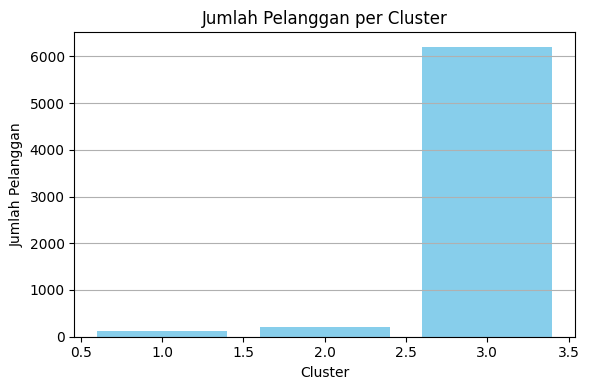

In [36]:
cluster_counts = agg_df['cluster'].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Pelanggan')
plt.title('Jumlah Pelanggan per Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Cluster 3 contains the majority of the customers, over 6,000.

Clusters 1 and 2 contain a much smaller number of customers, under 300 each.

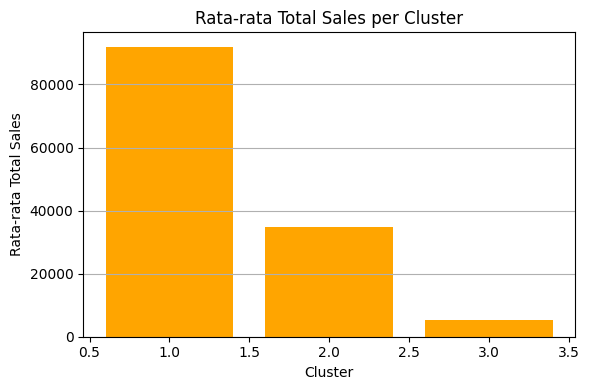

In [37]:
avg_sales = agg_df.groupby('cluster')['total_sales'].mean()

plt.figure(figsize=(6,4))
plt.bar(avg_sales.index, avg_sales.values, color='orange')
plt.xlabel('Cluster')
plt.ylabel('Rata-rata Total Sales')
plt.title('Rata-rata Total Sales per Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Cluster 1: Small in size (few customers), but very profitable, possibly VIP or loyal customers.

Cluster 2: Medium segment, likely contributing steadily but not significantly.

Cluster 3: Large volume, but low spenders, could be casual or price-sensitive buyers.

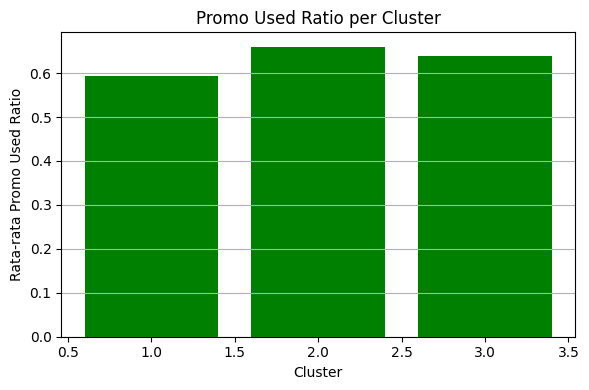

In [38]:
avg_promo = agg_df.groupby('cluster')['promo_used_ratio'].mean()

plt.figure(figsize=(6,4))
plt.bar(avg_promo.index, avg_promo.values, color='green')
plt.xlabel('Cluster')
plt.ylabel('Rata-rata Promo Used Ratio')
plt.title('Promo Used Ratio per Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Cluster 1: Uses promotions the least, aligns with earlier findings where this cluster had high total sales, suggesting they may not rely on discounts (possibly loyal or premium customers).

Cluster 2: Highly responsive to promotions, could be price-sensitive or promo-driven buyers.

Cluster 3: Also promotion-heavy, even though we previously saw they have the lowest total sales (likely low spend per transaction).

